In [40]:
import boto3
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use("ggplot")
# sns.set_theme(style="white")


load_dotenv()

LOCAL_DIR = "data"

In [6]:
os.listdir(LOCAL_DIR)

['feature_frame.parquet']

In [7]:

bb_df = pd.read_parquet("data/feature_frame.parquet", engine="fastparquet")

In [8]:
bb_df.variant_id.nunique()

976

In [9]:
info_cols = ["variant_id","order_id","user_id","created_at","order_date"]
label_col = "outcome"
feature_cols = [col for col in bb_df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type","vendor"]
binary_cols = ["ordered_before","abandoned_before","active_snoozed","set_as_regular"]
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [10]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [11]:
bb_df[["variant_id","order_id","outcome"]].head()

,variant_id,order_id,outcome
0,33826472919172,2807985930372,0.0
1,33826472919172,2808027644036,0.0
2,33826472919172,2808099078276,0.0
3,33826472919172,2808393957508,0.0
4,33826472919172,2808429314180,0.0


In [12]:
(
    bb_df.groupby("order_id")["user_id"]
    .nunique()
    .reset_index()
)["user_id"].unique()

array([1])

In [13]:
(
    bb_df.groupby("order_id")["user_id"]
    .nunique() > 1
    ).any()

False

Con esto vemos que la relación entre "order_id" y "user_id" es 1:1

In [14]:
(
    bb_df.groupby("user_id")["order_id"]
    .nunique()
    .reset_index()
    ).max()

user_id     5029635227780
order_id               16
dtype: int64

Sin embargo, como es obvio, un usuario puede hacer más de 1 pedido. El usuario "5029635227780" fue el que más pedidos hizo (16 pedidos), aunque luego no comprara

In [15]:
user = 5029635227780
(bb_df.loc[lambda df:df["user_id"] == user].outcome == 1).sum()

2

Únicamente compró dos ítems

<Axes: xlabel='order_id'>

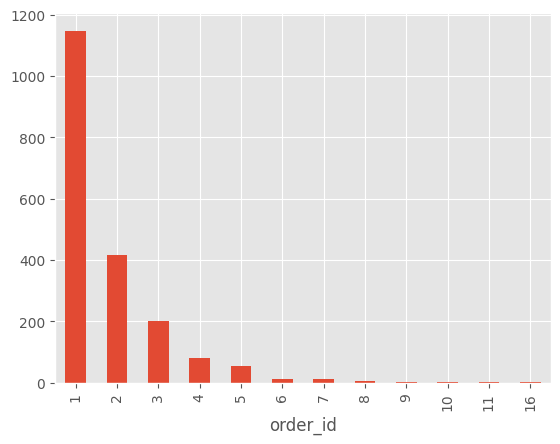

In [16]:
(
    bb_df.groupby("user_id")["order_id"]
    .nunique()
    .reset_index()
)["order_id"].value_counts().sort_index().plot(kind="bar")

In [ ]:
filtered_orders = ( 
    bb_df.groupby(["order_id"])["outcome"]
    .sum()
    .reset_index()
    .loc[lambda df:df["outcome"].ge(5)] 
)["order_id"]

filtered_orders

0       2807985930372
1       2808027644036
2       2808099078276
3       2808393957508
5       2808434524292
            ...      
3438    3643241300100
3441    3643254800516
3442    3643274788996
3443    3643283734660
3444    3643294515332
Name: order_id, Length: 2603, dtype: int64

In [55]:
filtered_df = bb_df.loc[lambda df:df["order_id"].isin(filtered_orders)].copy()
filtered_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [58]:
# Otra forma de hacerlo (como lo hace Guille en la corrección) con el método .pipe()

def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    order_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = order_size[order_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]

def format_date_columns(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df
        .assign(created_at=lambda x: pd.to_datetime(x.created_at))
        .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
    )

filtered_df = (
    bb_df
    .pipe(push_relevant_dataframe)
    .pipe(format_date_columns)
)

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   variant_id                        int64         
 1   product_type                      object        
 2   order_id                          int64         
 3   user_id                           int64         
 4   created_at                        datetime64[ns]
 5   order_date                        object        
 6   user_order_seq                    int64         
 7   outcome                           float64       
 8   ordered_before                    float64       
 9   abandoned_before                  float64       
 10  active_snoozed                    float64       
 11  set_as_regular                    float64       
 12  normalised_price                  float64       
 13  discount_pct                      float64       
 14  vendor                 

<Axes: xlabel='product_type'>

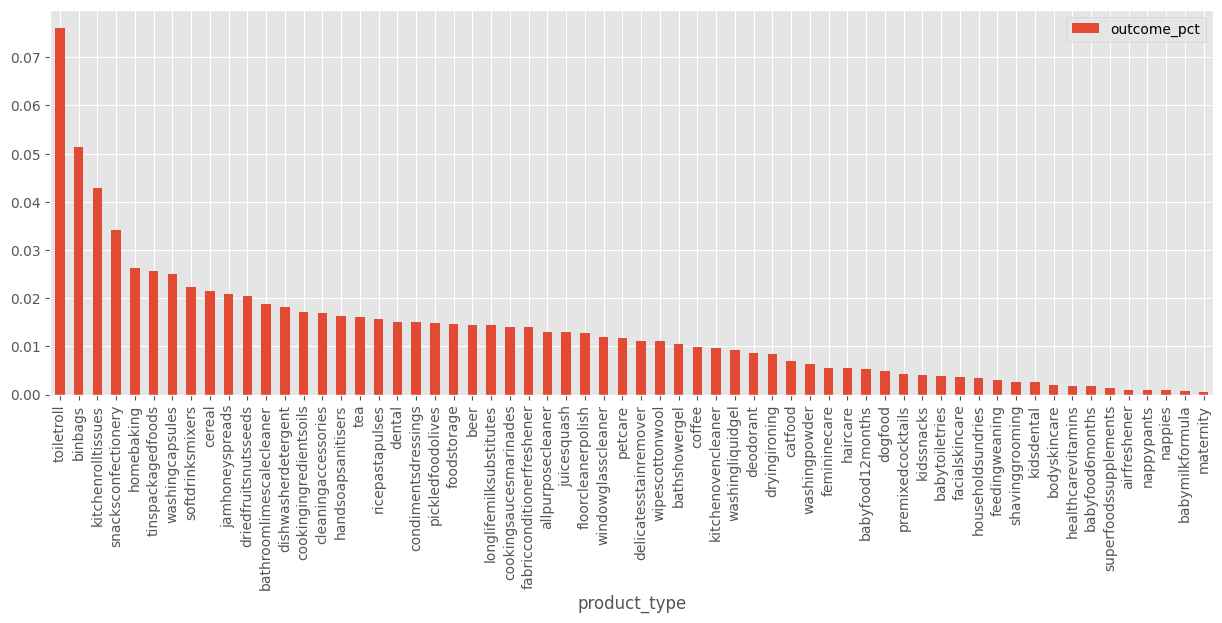

In [66]:
(
    filtered_df.groupby("product_type")["outcome"]
    .mean()
    .reset_index()
    .rename(columns = {"outcome":"outcome_pct"})
    .sort_values("outcome_pct", ascending=False)
    ).plot(kind="bar", x="product_type",figsize=(15,5))

<Axes: xlabel='product_type'>

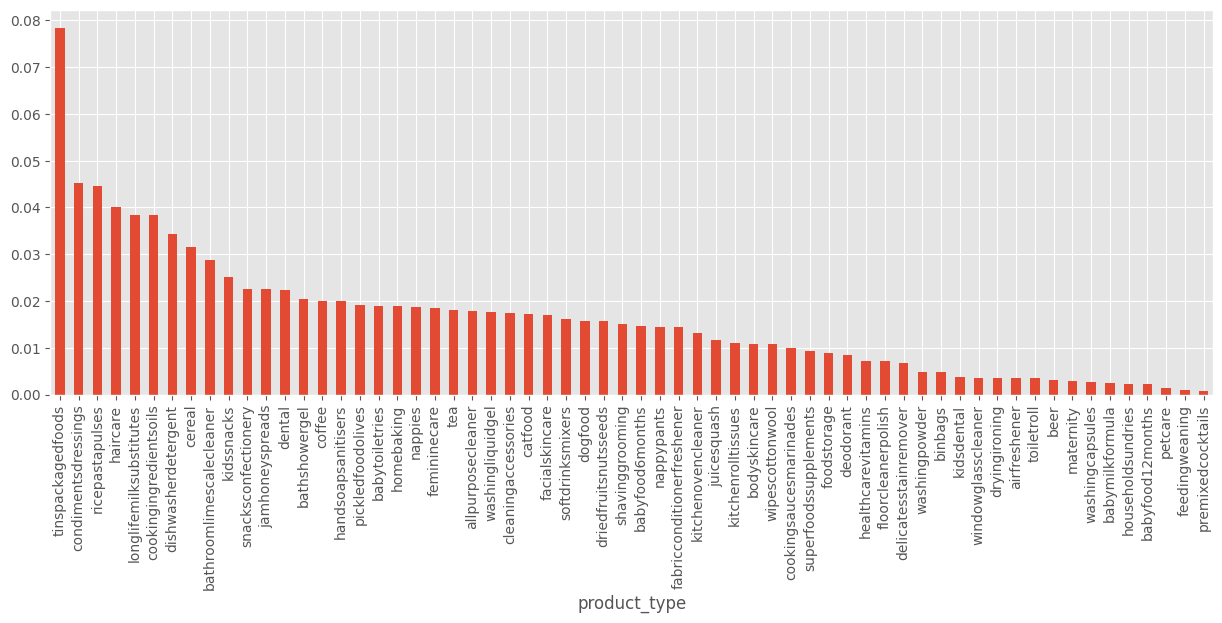

In [67]:
filtered_df.product_type.value_counts(normalize=True).plot(kind="bar",figsize=(15,5))

In [68]:
daily_orders = filtered_df.groupby("order_date").order_id.nunique()
daily_orders.head()


order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily orders')

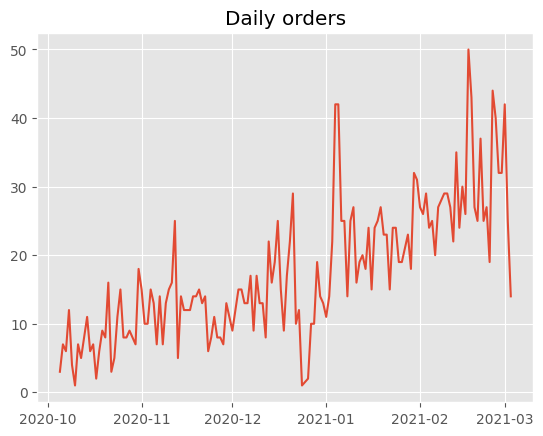

In [69]:
plt.plot(daily_orders, label="daily orders")
plt.title("Daily orders")

- Como se puede comprobar, hay una fuerte evolución temporal en el comportamiento de compra en el negocio, lo que nos viene a decir que las dinámicas de compra de los usuarios varían durante el período estudiado.
En este contexto, lo que tiene más sentido es realizar un **split de datos temporal**, de forma que en el training set no exista información futura y por tanto evitando information leakage.
- Information leakage ocurre cuando le damos al modelo cualquier información que no debería tener, ya que en producción NO la va a tener

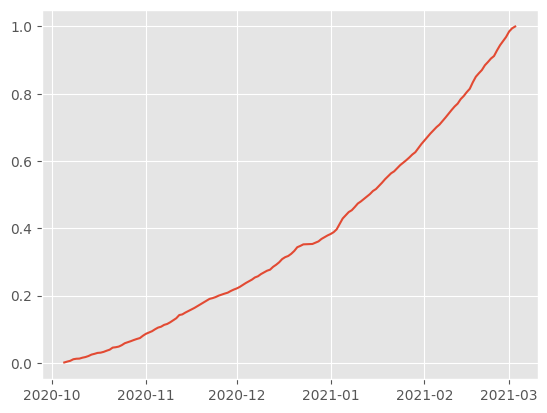

In [87]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()
plt.plot(cumsum_daily_orders)

Split temporal:
- Train: 70%
- Val: 20%
- Test: 10%

El split temporal se va a realizar en base al nº de pedidos, pero como esto no es constante en el tiempo, tendremos que hacer el split en base a la **suma acumulada**. Si se hiciera contando el nº de filas que representan el 70% en el df original:
- podríamos tener un train con pocos pedidos (si los primeros días tenían pocos),
- o un train con demasiados pedidos (si los últimos días concentraban muchos).

In [94]:
cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()

datetime.date(2021, 2, 4)

In [95]:
train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

In [100]:
train_val_cutoff

datetime.date(2021, 2, 4)

In [107]:
train_df = filtered_df[filtered_df.order_date <= train_val_cutoff]
val_df = filtered_df[
    (filtered_df.order_date > train_val_cutoff) & 
    (filtered_df.order_date <= val_test_cutoff)
    ]
test_df = filtered_df[filtered_df.order_date > val_test_cutoff]
test_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
3058,33826472919172,ricepastapulses,2928349577348,3920643883140,2021-02-23 00:05:23,2021-02-23,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3059,33826472919172,ricepastapulses,2928554311812,3909597462660,2021-02-23 07:31:17,2021-02-23,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3060,33826472919172,ricepastapulses,2928560537732,3879715569796,2021-02-23 07:47:37,2021-02-23,4,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,48.0,42.0,31.134053,7.0,30.0,24.27618
3062,33826472919172,ricepastapulses,2928594518148,3869171810436,2021-02-23 09:24:11,2021-02-23,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3063,33826472919172,ricepastapulses,2928611459204,3877728223364,2021-02-23 10:08:29,2021-02-23,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,38.0,30.0,24.27618


In [109]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   variant_id                        int64         
 1   product_type                      object        
 2   order_id                          int64         
 3   user_id                           int64         
 4   created_at                        datetime64[ns]
 5   order_date                        object        
 6   user_order_seq                    int64         
 7   outcome                           float64       
 8   ordered_before                    float64       
 9   abandoned_before                  float64       
 10  active_snoozed                    float64       
 11  set_as_regular                    float64       
 12  normalised_price                  float64       
 13  discount_pct                      float64       
 14  vendor                 

### Baseline

In [23]:
filtered_df["product_type_freq"] = filtered_df["product_type"].map(
    filtered_df["product_type"]
    .value_counts(normalize=True)
    )

filtered_df["vendor_freq"] = filtered_df["vendor"].map(
    filtered_df["vendor"]
    .value_counts(normalize=True)
    )

filtered_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_freq,vendor_freq
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0.044619,0.014435


In [24]:
cols_to_drop = filtered_df.select_dtypes(include=["object"]).columns
df = filtered_df.drop(columns=cols_to_drop)
df

,variant_id,order_id,user_id,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_freq,vendor_freq
0,33826472919172,2807985930372,3482464092292,3,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
1,33826472919172,2808027644036,3466586718340,2,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
2,33826472919172,2808099078276,3481384026244,4,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
3,33826472919172,2808393957508,3291363377284,2,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
5,33826472919172,2808434524292,3479090790532,3,0.0,0.0,0.0,0.0,0.0,0.081052,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,33826439594116,3643241300100,3864791220356,2,0.0,0.0,0.0,0.0,0.0,0.417186,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880544,33826439594116,3643254800516,3893722808452,3,0.0,0.0,0.0,0.0,0.0,0.417186,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880545,33826439594116,3643274788996,3883757174916,4,0.0,0.0,0.0,0.0,0.0,0.417186,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880546,33826439594116,3643283734660,3874925314180,7,0.0,0.0,0.0,0.0,0.0,0.417186,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203


In [25]:
df = df.drop(columns= ["variant_id","order_id","user_id"])
df

,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_freq,vendor_freq
0,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
1,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
2,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
3,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.038462,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
5,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.038462,2.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0.044619,0.014435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880541,2,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,0.000000,2.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880544,3,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,0.000000,2.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880545,4,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,0.000000,2.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203
2880546,7,0.0,0.0,0.0,0.0,0.0,0.417186,0.114360,0.000000,2.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392,0.007217,0.001203


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 22 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   user_order_seq                    int64  
 1   outcome                           float64
 2   ordered_before                    float64
 3   abandoned_before                  float64
 4   active_snoozed                    float64
 5   set_as_regular                    float64
 6   normalised_price                  float64
 7   discount_pct                      float64
 8   global_popularity                 float64
 9   count_adults                      float64
 10  count_children                    float64
 11  count_babies                      float64
 12  count_pets                        float64
 13  people_ex_baby                    float64
 14  days_since_purchase_variant_id    float64
 15  avg_days_to_buy_variant_id        float64
 16  std_days_to_buy_variant_id        float64

Correlation plot

<Axes: >

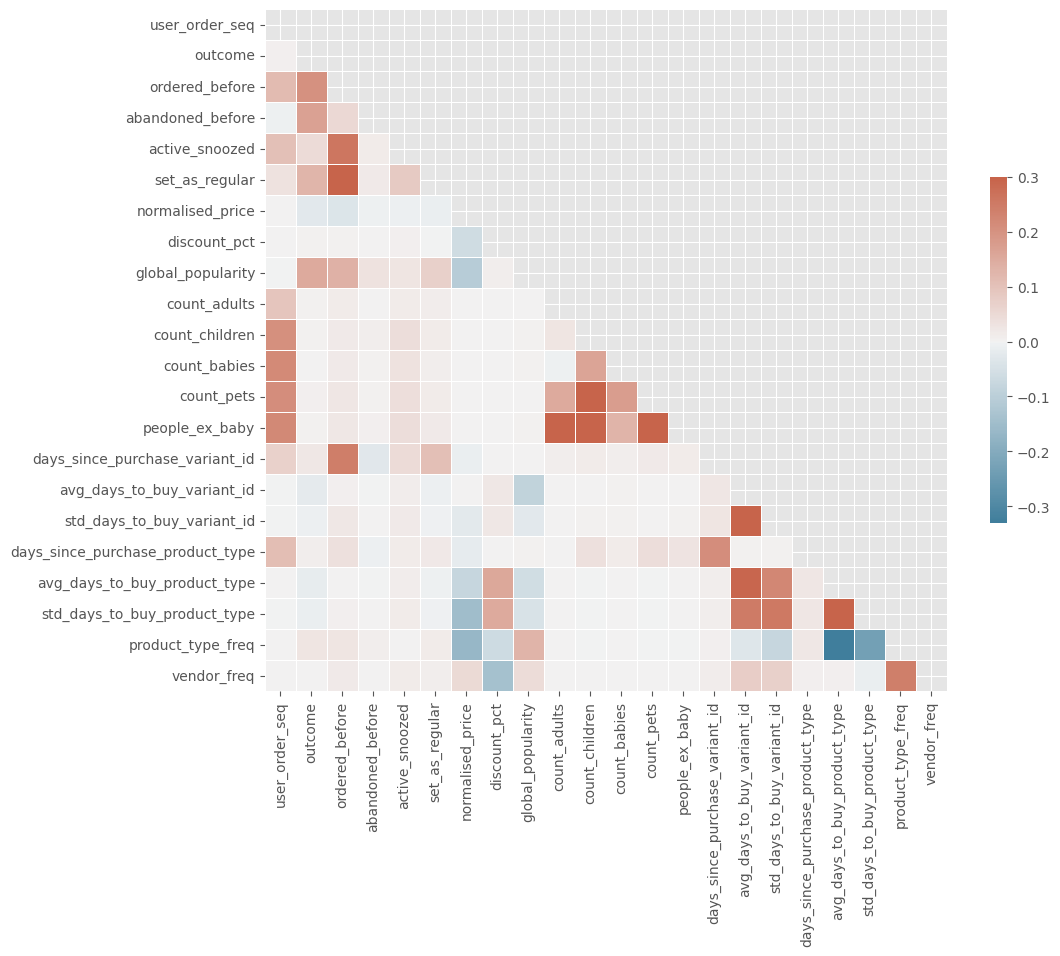

In [27]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Linear Regression

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [29]:
df.global_popularity

0          0.000000
1          0.000000
2          0.000000
3          0.038462
5          0.038462
             ...   
2880541    0.000000
2880544    0.000000
2880545    0.000000
2880546    0.000000
2880547    0.000000
Name: global_popularity, Length: 2163953, dtype: float64

In [30]:
X = df.drop(columns=["outcome"])
y = df["outcome"]


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)/len(df)}")
print(f"Val size:   {len(X_val)/len(df)}")
print(f"Test size:  {len(X_test)/len(df)}")


Train size: 0.6999999537882754
Val size:   0.15000002310586227
Test size:  0.15000002310586227


In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [35]:
y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)[:, 1]
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1:", f1_score(y_val, y_val_pred))

Accuracy: 0.9857945180579988
Precision: 0.6047058823529412
Recall: 0.054680851063829784
F1: 0.10029268292682927


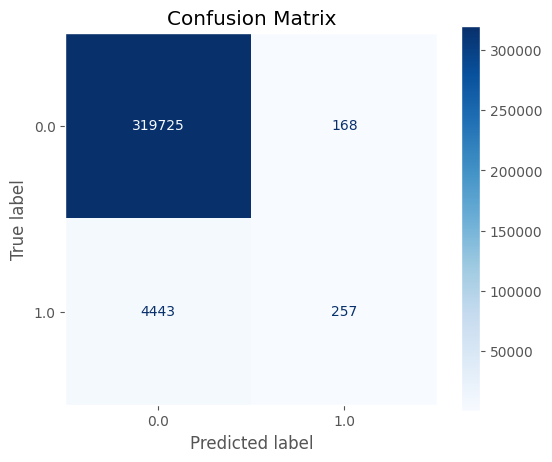

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_conf_matrix(y_val, y_val_pred):
    cm = confusion_matrix(y_val, y_val_pred)
    fig, ax = plt.subplots(figsize=(6,5), dpi=100)
    display = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    ax.set(title='Confusion Matrix')
    plt.grid(False)
    display.plot(ax=ax, cmap='Blues', colorbar=True)

plot_conf_matrix(y_val, y_val_pred)


In [37]:
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# Calcular FPR, TPR y AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
auc = roc_auc_score(y_val, y_val_proba)

# Mostrar la curva
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title(f"ROC Curve (AUC = {auc:.3f})")
plt.show()


NameError: name 'roc_auc_score' is not defined

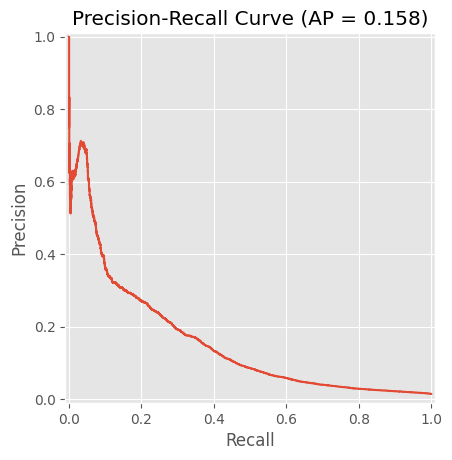

In [38]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
ap = average_precision_score(y_val, y_val_proba)

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title(f"Precision-Recall Curve (AP = {ap:.3f})")
plt.show()